In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy import stats

# Question 1

## **Part 1.1: Work**



#### Read Data

In [2]:
PATH_TO_Q1_DATA = 'data/HW1_Q1_Data.csv'
df = pd.read_csv(PATH_TO_Q1_DATA) 

In [3]:
df.head(1)

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,NT50,Sex,Race,Age,Remdesivir,Antibiotics,Chloroquines,Tocilizumab,Ards,Outcome
0,15518.25,11686.5,17408.0,2595.0,2977.5,4418.75,7988.75,10112.75,13740.75,2890.5,...,264.0,Male,Black,60-69,No,Yes,Yes,No,Yes,Died


#### Standardize Data in Columns 1-52

In [4]:
'''
 TODO: Standardize columns 1-52 by subtracting off mean of each column and scaling to unit variance
'''
# messing with ddof=231 causes issues with hierarchical clustering??
cols = df.columns.values.tolist()[0:52] # get list of columns names for columns 1-52

for col in cols:
    if '_zscore' not in col: # to allow re-execution of same cell multiple times
        col_zscore = col + '_zscore' # add column for zscore
    df[col_zscore] = (df[col] - df[col].mean())/ df[col].std() # z =(x-μ)/σ

#### Cluster Standardized Data in Columns 1-52

- Distance Measure: I chose to use Euclidean distance because columns 1-52 are real valued.
- Quality Measure: I chose to use Silhouette Coefficient because the true labels are unknown.

In [5]:
kmeans_possible_cluster_nums = [2,3,4,5,6,7,8,9,10] # 1 < k < 11
df_standardized_only = df.iloc[:,61:] # get dataframe with standardized columns only

kmeans_cluster_quality_scores = []
for k in kmeans_possible_cluster_nums:
    '''
    TODO: 1. Fit data to k clusters using imported clustering algorithm
          2. Compute quality of results for k clusters using imported
             cluster quality metric and store in a list
    '''
    kmeans = KMeans(n_clusters=k).fit(df_standardized_only)
    labels = kmeans.labels_
    score = metrics.silhouette_score(df_standardized_only, labels) # quality
    kmeans_cluster_quality_scores.append(score)

#### Visualize Cluster Quality Metrics

In [6]:
# Creates line chart to visualize values of cluster quality metric for each possible number of clusters
def plotMetricByK(metric_name, metric_results, num_possible_clusters, title, xlabel, PATH_TO_SAVE=None):
  '''
  metric_name: Name of cluster quality metric for title and axis label
  metric_results: List containing value of metric, in order, for each
                  possible number of clusters
  PATH_TO_SAVE: Path of file to save plot. If path is not provided, image is not saved
  '''

  plt.clf()

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(metric_name)
  plt.plot(num_possible_clusters, metric_results)
  
  if PATH_TO_SAVE:
    plt.savefig(PATH_TO_SAVE)

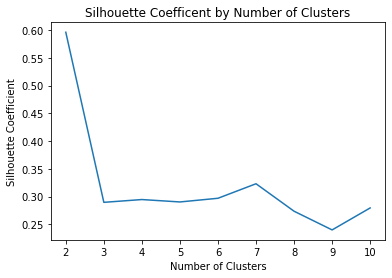

In [7]:
'''
 TODO: Plot your choice of cluster quality metric by cluster number to help determine k.

 TIP: If using the above function, place each function call in a separate 
      cell to visualize multiple cluster quality metrics
'''
plotMetricByK("Silhouette Coefficient", 
              kmeans_cluster_quality_scores, 
              kmeans_possible_cluster_nums, 
              title='Silhouette Coefficent by Number of Clusters',
              xlabel='Number of Clusters')

#### Dimensionality Reduction and Visualization of Data

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

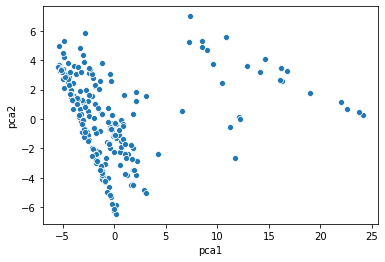

In [8]:
# use PCA to visualize data
pca = PCA(n_components=2).fit_transform(df_standardized_only)
df_pca_plot = pd.DataFrame(pca, columns=['pca1','pca2'])
sns.scatterplot(x='pca1', y='pca2', data=df_pca_plot, legend='full')

## **Part 1.1: Answer**

How many clusters are there in the data? **There appear to be two clusters.**

Explanation: **Good clustering is indicated when the Silhouette Coefficient is close to 1. The Silhouette Coefficient is closest to 1 for two clusters and is much lower for other clustering sizes.**

## **Part 1.2: Work**

#### Cluster Standardized Data in Columns 1-52 Using Chosen k-value

In [9]:
'''
  TODO: Cluster data with the number of clusters you determined in part 1.1 and store resulting labels
'''
kmeans = KMeans(n_clusters=2).fit(df_standardized_only)
kmeans_labels = kmeans.labels_

# add to DataFrame
df = pd.DataFrame(df)
df['cluster']=kmeans_labels

In [10]:
df.head(1)

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,RBD ADCD_zscore,N ADCD_zscore,S NKD-CD107a_zscore,RBD NKD-CD107a_zscore,N NKD-CD107a_zscore,S NKD-MIP1b_zscore,RBD NKD-MIP1b_zscore,N NKD-MIP1b_zscore,NT50_zscore,cluster
0,15518.25,11686.5,17408.0,2595.0,2977.5,4418.75,7988.75,10112.75,13740.75,2890.5,...,-0.411877,0.450513,-0.02381,-0.180116,-0.576487,-0.586417,-1.100901,-0.542606,1.019302,0


#### Univariate Analysis

In [11]:
'''
  TODO: Find 4 variables that have statistically significant differences between values in the clusters (i.e p < 0.05 using pairwise t-tests)
'''
# split data by cluster
df_cluster0=df[df['cluster']==0]
df_cluster1=df[df['cluster']==1]

# create a dataframe to store test results
cols = df_standardized_only.columns.values.tolist()  # get names of standarized columns
df_ttest = pd.DataFrame(columns=['Metric','Statistic','P_value']).astype(dtype= {'Metric':'object', 'Statistic':'float64','P_value':'float64'})

# Welch's t-test
for col in cols:
    (stat, pvalue) = stats.ttest_ind(df_cluster0[col], df_cluster1[col], equal_var=False)
    new_row = pd.Series([col,stat,pvalue], index = df_ttest.columns)
    df_ttest = df_ttest.append(new_row, ignore_index=True)

In [12]:
print(df_cluster0.shape)
print(df_cluster1.shape)
df_ttest

(207, 114)
(25, 114)


,Metric,Statistic,P_value
0,S IgG1_zscore,-10.536886,1.647515e-10
1,RBD IgG1_zscore,-9.685497,8.688933e-10
2,N IgG1_zscore,-17.543949,2.258925e-15
3,S IgG2_zscore,-16.184907,1.795776e-14
4,RBD IgG2_zscore,-14.480079,2.141806e-13
5,N IgG2_zscore,-11.995939,1.177223e-11
6,S IgG3_zscore,-16.287045,5.949278e-15
7,RBD IgG3_zscore,-9.217968,2.265051e-09
8,N IgG3_zscore,-6.694336,6.284985e-07
9,S IgG4_zscore,-8.630050,7.675713e-09


In [13]:
# find metrics with four lowest P-values
df_ttest.nsmallest(4,['P_value'])['Metric'].to_list()

['RBD NKD-CD107a_zscore', 'N IgG1_zscore', 'RBD IgA1_zscore', 'S IgG3_zscore']

## **Part 1.2: Answer**

Four variables with statistically significant differences between values:
- RBD NKD-CD107a
- N IgG1
- RBD IgA1
- S IgG3

#### Visualization

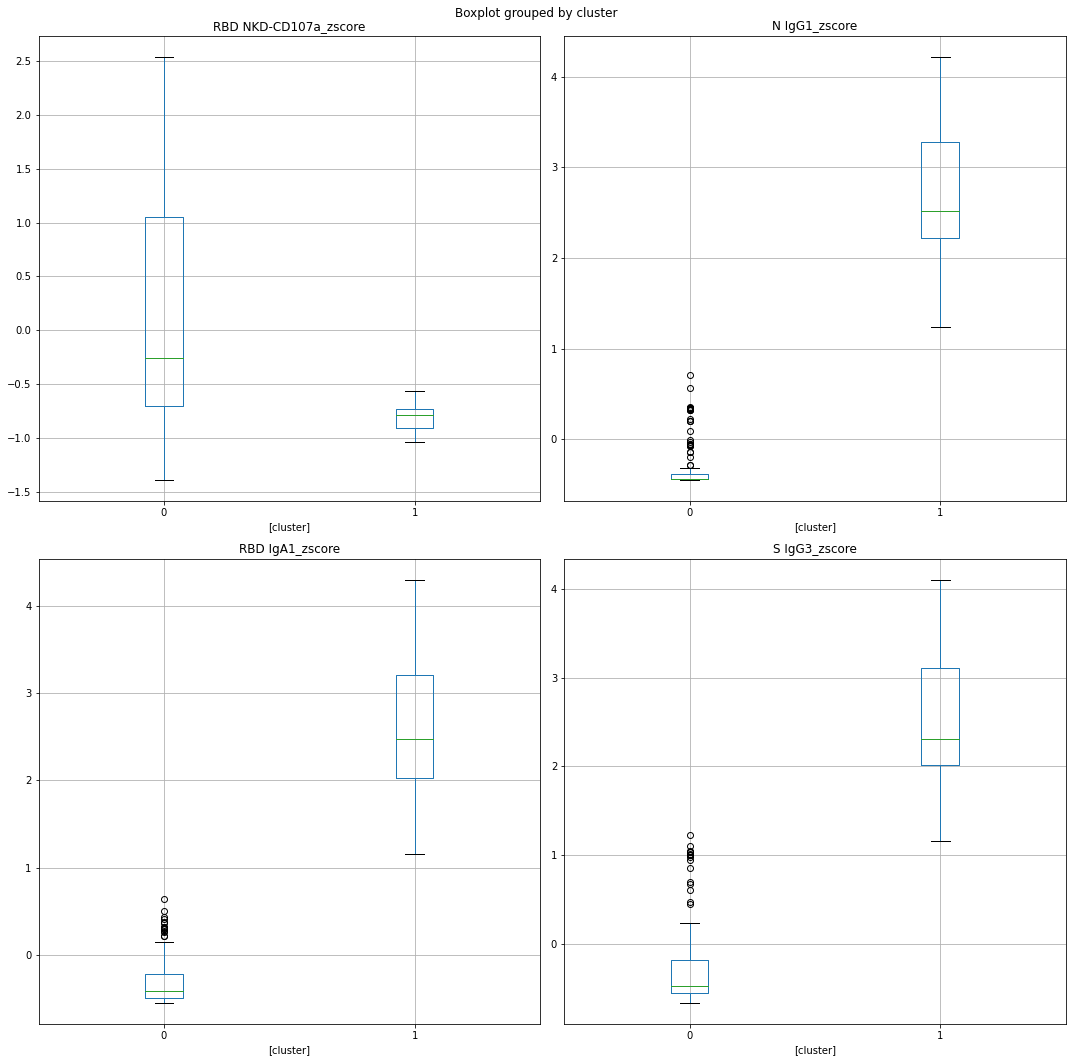

In [14]:
'''
  TODO: Create and display boxplots for each of the 4 variables like those in Fig 1. from the paper by Wu et al

  TIP: 1. If you add the cluster labels as an additional column to the dataframe, then you can follow the example at https://www.pythonprogramming.in/boxplot-group-by-column-data.html
       2. If you want to use subplots to put all 4 boxplots in the same figure, you can plot the dataframes on a specific subplot using the ax keyword. For example,
          
          fig, axs = plt.subplots(2, 2)

          df.boxplot(column=['Variable'], by=['Cluster'], ax=axs[0,0])
          df.boxplot(column=['Variable'], by=['Cluster'], ax=axs[0,1])
''' 
fig, axs = plt.subplots(2,2, figsize=(15,15))

df.boxplot(column=['RBD NKD-CD107a_zscore'], by=['cluster'], ax=axs[0,0])
df.boxplot(column=['N IgG1_zscore'], by=['cluster'], ax=axs[0,1])
df.boxplot(column=['RBD IgA1_zscore'], by=['cluster'], ax=axs[1,0])
df.boxplot(column=['S IgG3_zscore'], by=['cluster'], ax=axs[1,1])


plt.tight_layout() # ensures all labels are visible

## **Part 1.3: Work**


#### Analysis of Columns 53-61

In [15]:
# Formats Pandas series to string of form 'index_1: value_1, ..., index_n:, value_n' w/ indexes alphabetically sorted
def formatValueCounts(value_counts):
  '''
    value_counts: Pandas series
  '''
  count_string = value_counts.to_string()
  formatted_counts = [': '.join(count.split()) for count in count_string.split('\n')]
  formatted_counts.sort()
  return ',\n '.join(formatted_counts)

# Creates table summarizing data by cluster and categorical feature
def plotSummaryTable(cellText, PATH_TO_SAVE=None):
  '''
  cellText: num_clusters x 9 2D List where cellText[i][j] contains a string summarizing
            the statistics for cluster i and column (53 + j) in the data
  PATH_TO_SAVE: Path of file to save plot. If path is not provided, image is not saved
  '''

  k = len(cellText)
  colLabels = [f'Cluster {i + 1}' for i in range(k)]

  rowLabels = list(df.columns)[52:61]

  cellText = np.array(cellText).T

  plt.figure(figsize=(10,10))
  table = plt.table(cellText, 
              colLabels=colLabels,
              colColours=['#D3D3D3'] * len(colLabels),
              rowLabels=rowLabels,
              rowColours=['#D3D3D3'] * len(rowLabels),
              cellLoc='center',
              loc='upper center')
  table.scale(2,5)
  table.auto_set_font_size(True) # was false
#   table.set_fontsize(8)

  plt.axis('off')
  plt.grid(False)

  if PATH_TO_SAVE:
    plt.savefig(PATH_TO_SAVE)

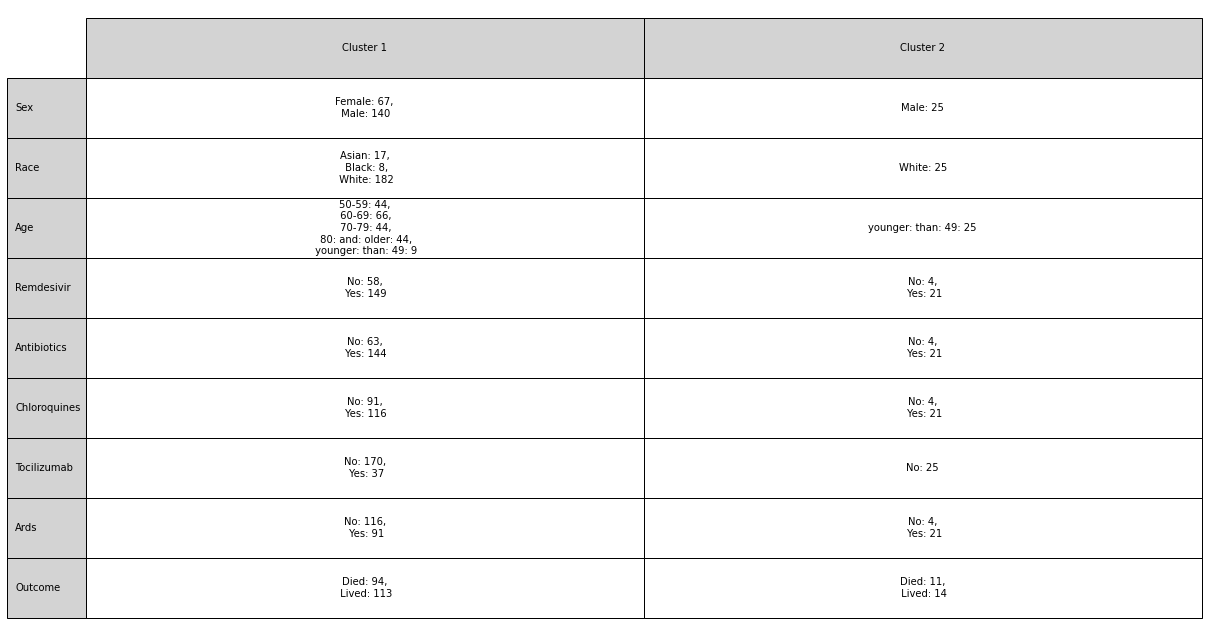

In [16]:
'''
  TODO: Create a table where the rows correspond to the variables in columns 53-61, and the columns correspond to the k clusters you identified.
        For each cell in the table, put summary statistics for that (variable, cluster) pair

  TIP: 1. If you create a 2D list, cellText, where cellText[i][j] contains a string summarizing the statistics for cluster i and column (53 + j) in
          the data, you can pass this into plotSummaryTable (provided above) to automatically create the table with matplotlib
       2. If you use value_counts() from Pandas, you can pass the resulting series to formatValueCounts (provided above) to convert it to a formatted string
'''
#'Sex','Race', 'Age', 'Remdesivir', 'Antibiotics', 'Chloroquines','Tocilizumab', 'Ards', 'Outcome'

# create 2d list to contain results
rows=2 # 2 clusters
columns=9 # 9 categorical columns
cellText=[[''] * columns for i in range(rows)]


# get summary stats for each categorical column
categorical_cols = df.columns.values.tolist()[52:61]
for i, col in enumerate(categorical_cols):
    for cluster in range(0,rows):
        df_one_cluster = df[df['cluster']==cluster] # select data for only one cluster
        formatted = formatValueCounts(df_one_cluster[col].value_counts())
        cellText[cluster][i]=formatted

output_table = plotSummaryTable(cellText)
output_table

#### Check for Statistical Significance

In [41]:
# Fisher's Exact Test
# Sex
contingency_table_sex=[[140,67],[25,0]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_sex)
print("Fisher's Exact Test by Sex (pvalue):",pvalue)

# Age
contingency_table_age=[[9,198],[25,0]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_age)
print("Fisher's Exact Test by Age (pvalue):",pvalue)

# Race
contingency_table_race=[[182,25],[25,0]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_race)
print("Fisher's Exact Test by Race (pvalue):",pvalue)

# Outcome
contingency_table_outcome=[[94,113],[11,14]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_outcome)
print("Fisher's Exact Test by Outcome (pvalue):",pvalue)

Fisher's Exact Test by Sex (pvalue): 0.00022891132432224163
Fisher's Exact Test by Age (pvalue): 2.2681546040326153e-26
Fisher's Exact Test by Race (pvalue): 0.08516952941820745
Fisher's Exact Test by Outcome (pvalue): 1.0


## **Part 1.3: Answer**

Are any of the clusters significantly enriched for some particular value? 

**Yes. One cluster consists entirely of white males younger than 49 who didn't take Tocilizumab. The second cluster is largely white individuals older than 49, but this simply the remainder of the patients so these details are unlikely to be relevant on their own. Roughly half of the patients died in each cluster, so it's not clear if the clusters are clinically relevant.**

**Regarding statistical significance, Fisher's Exact Test indicate clusters are significantly enriched by sex and age but not by race or outcome.**

## **Part 1.4: Work**

#### Cluster Variables for Columns 1-52
- Distance Measure: I chose to use Euclidean distance because columns 1-52 are real valued.
- Quality Measure: I chose to use Silhouette Coefficient because there are no "true" labels with hierarchical clusters (so the true labels are unknown).

In [18]:
'''
TODO: Cluster the numeric variables (Columns 1-52) to find clusters among variables
'''
hier_possible_distance_thresholds = list(range(1,30))
df_numeric_variables = df_standardized_only.T # transpose data to cluster by metric

# hierarchical clustering for different distance thresholds
h_quality_scores = []

for d in hier_possible_distance_thresholds:
    hier = AgglomerativeClustering(n_clusters=None, distance_threshold=d).fit(df_numeric_variables)
    h_labels = hier.labels_
    score = metrics.silhouette_score(df_numeric_variables, h_labels)
    h_quality_scores.append((d,score))

In [19]:
h_quality_scores

[(1, 0.04381498465207157),
 (2, 0.061028385197819564),
 (3, 0.13279712186854872),
 (4, 0.15168559663433792),
 (5, 0.15012628184636384),
 (6, 0.18787001513529739),
 (7, 0.24404908059887112),
 (8, 0.2557911405197007),
 (9, 0.2601938392283203),
 (10, 0.28971297152176684),
 (11, 0.3109277177498267),
 (12, 0.3109277177498267),
 (13, 0.33004434833827606),
 (14, 0.33004434833827606),
 (15, 0.3348582675061609),
 (16, 0.3348582675061609),
 (17, 0.31947491922547433),
 (18, 0.31566997920796314),
 (19, 0.3096641777391753),
 (20, 0.29965051732110354),
 (21, 0.2901239063816258),
 (22, 0.2901239063816258),
 (23, 0.2901239063816258),
 (24, 0.2901239063816258),
 (25, 0.26250368170546834),
 (26, 0.26250368170546834),
 (27, 0.26250368170546834),
 (28, 0.26250368170546834),
 (29, 0.26250368170546834)]

#### Visualization 1 - Scatterplot

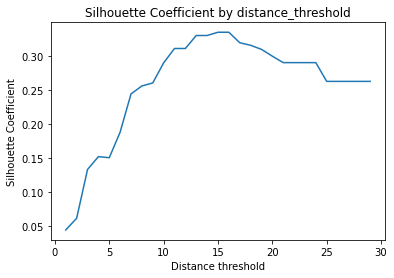

In [20]:
# get scores only
distances,scores = zip(*h_quality_scores)

plotMetricByK('Silhouette Coefficient', 
              scores, 
              hier_possible_distance_thresholds,
             title='Silhouette Coefficient by distance_threshold',
             xlabel='Distance threshold')

#### Visualization 2 - Dendrogram

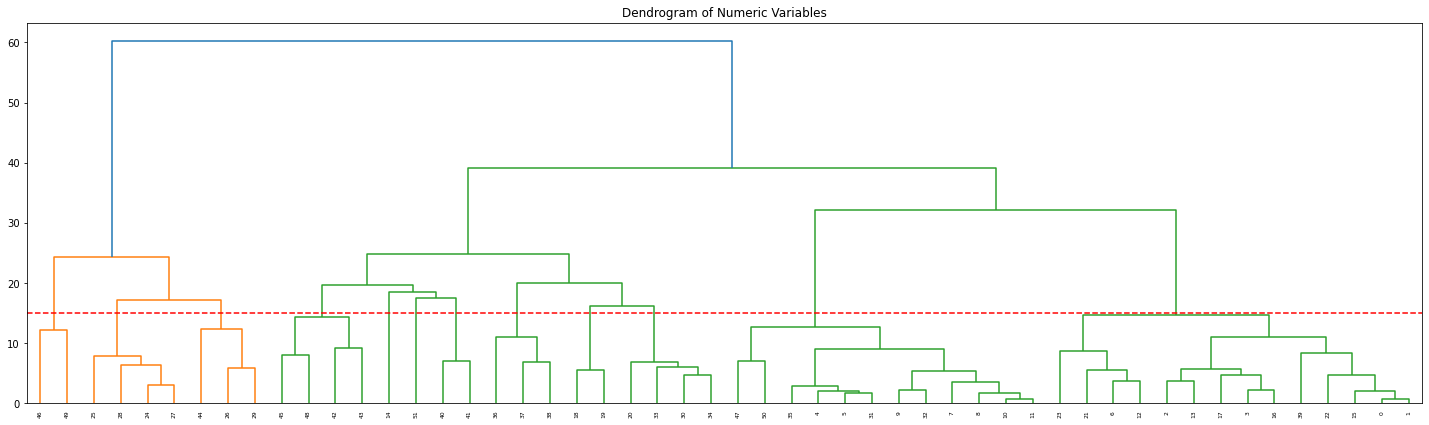

In [21]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(25,7))
plt.title("Dendrogram of Numeric Variables")
dend = shc.dendrogram(shc.linkage(df_numeric_variables, method='ward')) # method??
plt.axhline(y=15, color='r', linestyle='--')
plt.show()

## **Part 1.4: Answer**

How many clusters are there in the numeric variables? **There appear to be 12 clusters of variables.** 

Explanation: **When hierarchical clustering is performed, the quality measure (silhouette coefficient) is highest when the distance measure is 15 or 16. Choosing 15 as the distance threshold results in 12 clusters.**

## **Part 1.5: Work**

#### Cluster Variables for Columns 1-52 using chosen distance threshold

In [22]:
# determine clusters for variables 1-52
hier = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(df_numeric_variables) #?? distance threshold
h_labels = hier.labels_
h_labels

# add clusters to data
df_numeric_variables['variable_cluster']=h_labels
df_numeric_variables.sort_values(by=['variable_cluster'])['variable_cluster']

S IgG1_zscore             0
S ADNP_zscore             0
N FcRg2A_zscore           0
RBD FcRg2A_zscore         0
S FcRg2A_zscore           0
N IgA2_zscore             0
RBD IgA2_zscore           0
RBD IgA1_zscore           0
S IgA1_zscore             0
S IgA2_zscore             0
RBD IgG1_zscore           0
S IgG3_zscore             0
N IgG1_zscore             0
S IgG2_zscore             0
S ADCD_zscore             1
RBD ADCD_zscore           1
S NKD-MIP1b_zscore        1
S NKD-CD107a_zscore       1
RBD NKD-CD107a_zscore     2
RBD NKD-MIP1b_zscore      2
N RCA_zscore              3
N NKD-MIP1b_zscore        3
RBD IgG4_zscore           3
S IgG4_zscore             3
N NKD-CD107a_zscore       3
N IgG2_zscore             3
N SNA_zscore              3
RBD IgG3_zscore           3
N IgG3_zscore             3
N IgG4_zscore             3
RBD IgG2_zscore           3
RBD SNA_zscore            3
RBD FcRg2b_zscore         4
S FcRg3A_zscore           4
S FcRg2b_zscore           4
RBD FcRg3A_zscore   

#### Build low-dimensional dataset

In [23]:
'''
TODO: 1. Choose a representative variable from each cluster you determined in Part 1.4
         and create a low-dimensional version of the data using those variables
      2. Re-cluster the data using the reduced representation using the same 
         choices you made for part 1.1.
'''
df_reduced_variables = df.filter(items=['N IgG1_zscore',
                                        'RBD ADCD_zscore',
                                        'N ADCD_zscore',
                                        'N IgG2_zscore',
                                        'RBD FcRg2b_zscore',
                                        'RBD NKD-CD107a_zscore',
                                        'NT50_zscore',
                                        'N ADCP_zscore',
                                        'N ADNP_zscore',
                                        'N IgM_zscore',
                                        'N IgA1_zscore',
                                        'RBD IgM_zscore'])
df_reduced_variables.head(1)

,N IgG1_zscore,RBD ADCD_zscore,N ADCD_zscore,N IgG2_zscore,RBD FcRg2b_zscore,RBD NKD-CD107a_zscore,NT50_zscore,N ADCP_zscore,N ADNP_zscore,N IgM_zscore,N IgA1_zscore,RBD IgM_zscore
0,-0.390835,-0.411877,0.450513,-0.42364,-1.89693,-0.180116,1.019302,-0.90188,-0.902438,-0.624357,-0.306014,1.41559


#### Cluster Low-Dimensional Standardized Data in Columns 1-52

In [24]:
kmeans_possible_cluster_nums = [2,3,4,5,6,7,8,9,10] # 1 < k < 11

cluster_quality_scores = []
for k in kmeans_possible_cluster_nums:
    kmeans = KMeans(n_clusters=k).fit(df_reduced_variables)
    labels = kmeans.labels_
    score = metrics.silhouette_score(df_reduced_variables, labels) # quality
    cluster_quality_scores.append(score)

#### Visualize

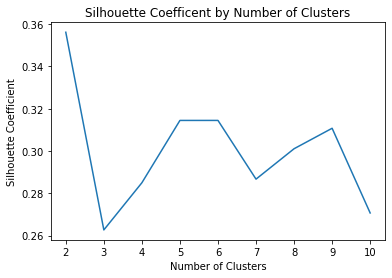

In [25]:
plotMetricByK("Silhouette Coefficient", 
              cluster_quality_scores, 
              kmeans_possible_cluster_nums, 
              title='Silhouette Coefficent by Number of Clusters',
              xlabel='Number of Clusters')

#### Cluster Low-Dimensional Standardized Data in Columns 1-52 using chosen cluster size

In [26]:
kmeans = KMeans(n_clusters=2).fit(df_reduced_variables)
labels = kmeans.labels_

df['low dimension cluster']=labels  # add low dimension clusters

In [27]:
df.head(1)

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,N ADCD_zscore,S NKD-CD107a_zscore,RBD NKD-CD107a_zscore,N NKD-CD107a_zscore,S NKD-MIP1b_zscore,RBD NKD-MIP1b_zscore,N NKD-MIP1b_zscore,NT50_zscore,cluster,low dimension cluster
0,15518.25,11686.5,17408.0,2595.0,2977.5,4418.75,7988.75,10112.75,13740.75,2890.5,...,0.450513,-0.02381,-0.180116,-0.576487,-0.586417,-1.100901,-0.542606,1.019302,0,1


## **Part 1.5: Answer**

Representative Variables: 

- N IgG1
- RBD ADCD
- N ADCD
- N IgG2
- RBD FcRg2b
- RBD NKD-CD107a
- NT50
- N ADCP
- N ADNP
- N IgM
- N IgA1
- RBD IgM

How many clusters are there in the numeric variables? **Base on the Silhouette Coefficient, there are 2.**

Explanation: **The Silhouette Coefficient is closest to 1 for two clusters and is lower for other clusterings.**

## **Part 1.6: Work**

#### Analysis of Columns 53-61 using low-dimension clusters

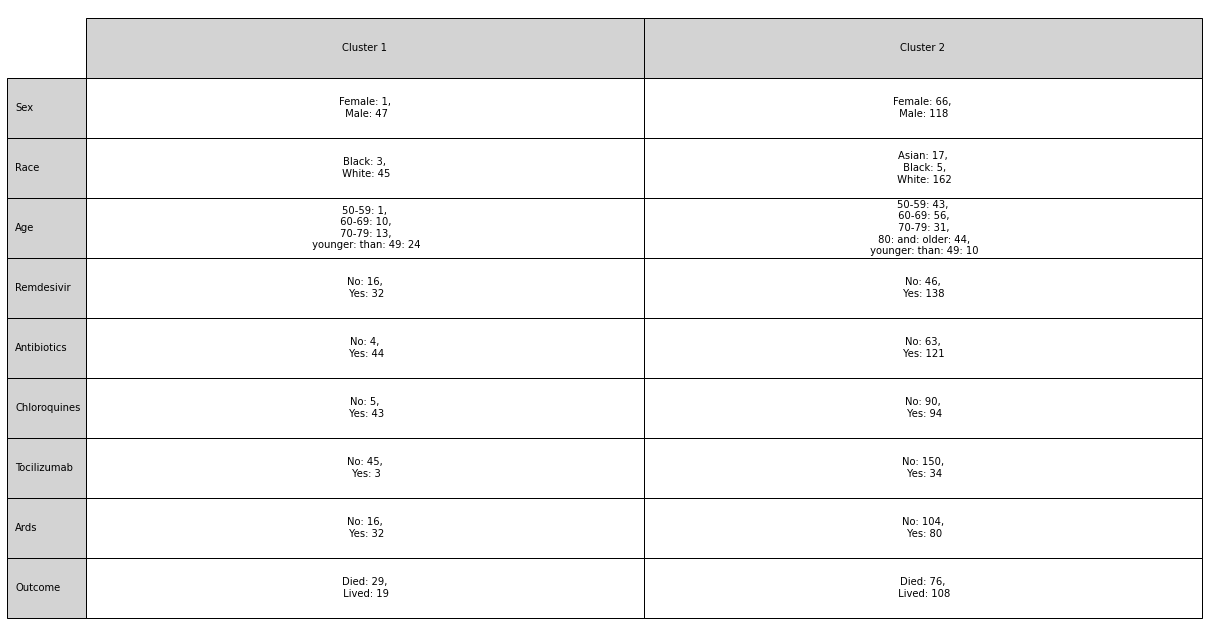

In [29]:
'''
  TODO: Create a table where the rows correspond to the variables in columns 53-61, and the columns correspond to the k clusters you identified.
        in part 1.5. For each cell in the table, put summary statistics for that (variable, cluster) pair
'''
# create 2d list to contain results
rows=2 # clusters
columns=9 # categorical columns
cellText=[[''] * columns for i in range(rows)]


# get summary stats for each categorical column
categorical_cols = df.columns.values.tolist()[52:61]
for i, col in enumerate(categorical_cols):
    for cluster in range(0,rows):
        df_one_cluster = df[df['low dimension cluster']==cluster] # select data for only one cluster
        formatted = formatValueCounts(df_one_cluster[col].value_counts())
        cellText[cluster][i]=formatted

output_table = plotSummaryTable(cellText)
output_table

#### Check for Statistical Significance

In [42]:
# Fisher's Exact Test
# Sex
contingency_table_sex=[[1,47],[66,118]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_sex)
print("Fisher's Exact Test by Sex (pvalue):",pvalue)

# Age
contingency_table_age=[[24,24],[10,174]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_age)
print("Fisher's Exact Test by Age (pvalue):",pvalue)

# Race
contingency_table_race=[[45,3],[162,22]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_race)
print("Fisher's Exact Test by Race (pvalue):",pvalue)

# Outcome
contingency_table_outcome=[[29,19],[76,108]]
oddsratio, pvalue=stats.fisher_exact(contingency_table_outcome)
print("Fisher's Exact Test by Outcome (pvalue):",pvalue)

Fisher's Exact Test by Sex (pvalue): 4.4400119657009405e-07
Fisher's Exact Test by Age (pvalue): 4.585251363087667e-12
Fisher's Exact Test by Race (pvalue): 0.30828126775456877
Fisher's Exact Test by Outcome (pvalue): 0.022428579034948177


## **Part 1.6: Answer**

Are any of the clusters significantly enriched for some particular value? 

**One cluster consists almost entirely of white males, with an outcome of death 60% of the time. There are twice as many males in that cluster than when the data was clustered using higher-dimensional data.**

**Regarding statistical significance, Fisher's Exact Test indicate clusters are significantly enriched by sex, age, and outcome but not by race.**